In [337]:
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter

# doc2vec tool
import gensim
from gensim.models import doc2vec

# sklearn classification 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Prepraring for classifiaction

## Computing new cells

In [2]:
# loading data
reviews_df = pd.read_csv('./data/reviews_clean.csv',
                        converters={'Review_lemmatized': pd.eval}) # just this used
                        #converters={'Review_lemmatized': pd.eval, 'Review_stopwords': pd.eval, 'Review_bigrams': pd.eval})

In [3]:
reviews_df

,Review,Rating,Review_processed,Review_lemmatized,Review_stopwords,Review_bigrams
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...","['nice', 'hotel', 'expensive', 'parking', 'got...","[('nice', 'hotel'), ('hotel', 'expensive'), ('..."
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...","['ok', 'nothing', 'special', 'charge', 'diamon...","[('ok', 'nothing'), ('nothing', 'special'), ('..."
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattl...,"[nice, room, not, experience, hotel, monaco, s...","['nice', 'room', 'experience', 'hotel', 'monac...","[('nice', 'room'), ('room', 'experience'), ('e..."
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,"[unique, great, stay, wonderful, time, hotel, ...","['unique', 'great', 'stay', 'wonderful', 'time...","[('unique', 'great'), ('great', 'stay'), ('sta..."
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,"[great, stay, great, stay, went, seahawk, game...","['great', 'stay', 'great', 'stay', 'went', 'se...","[('great', 'stay'), ('stay', 'great'), ('great..."
...,...,...,...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,best kept secret rd time staying charm not sta...,"[best, kept, secret, rd, time, staying, charm,...","['best', 'kept', 'secret', 'rd', 'time', 'stay...","[('best', 'kept'), ('kept', 'secret'), ('secre..."
20487,great location price view hotel great quick pl...,4,great location price view hotel great quick pl...,"[great, location, price, view, hotel, great, q...","['great', 'location', 'price', 'view', 'hotel'...","[('great', 'location'), ('location', 'price'),..."
20488,"ok just looks nice modern outside, desk staff ...",2,ok just looks nice modern outside desk staff n...,"[ok, just, look, nice, modern, outside, desk, ...","['ok', 'look', 'nice', 'modern', 'outside', 'd...","[('ok', 'look'), ('look', 'nice'), ('nice', 'm..."
20489,hotel theft ruined vacation hotel opened sept ...,1,hotel theft ruined vacation hotel opened sept ...,"[hotel, theft, ruined, vacation, hotel, opened...","['hotel', 'theft', 'ruined', 'vacation', 'hote...","[('hotel', 'theft'), ('theft', 'ruined'), ('ru..."


In [4]:
reviews_df['words_number'] = reviews_df.Review_lemmatized.apply(lambda x: len(x))

In [101]:
reviews_df['commas'] = reviews_df.Review.apply(lambda review_text: review_text.count(','))

In [111]:
# computing average length of a sentence
# there are no '.' so I use ','
# not sure if it should be used since there are no stopwors
# it also has a bug :D, it counts spaces and there is always an extra one 
reviews_df['average_length'] = reviews_df.Review.apply(lambda review_text: np.mean([len(sentence.split(' ')) for sentence in review_text.split(',')]))

In [5]:
# TODO: optimize
all_words = []

for rev in reviews_df.Review_lemmatized:
    all_words.extend(rev)
    
len(all_words)

2092254

In [6]:
word_occurence_number = pd.DataFrame.from_dict(Counter(all_words), orient='index')

<AxesSubplot: >

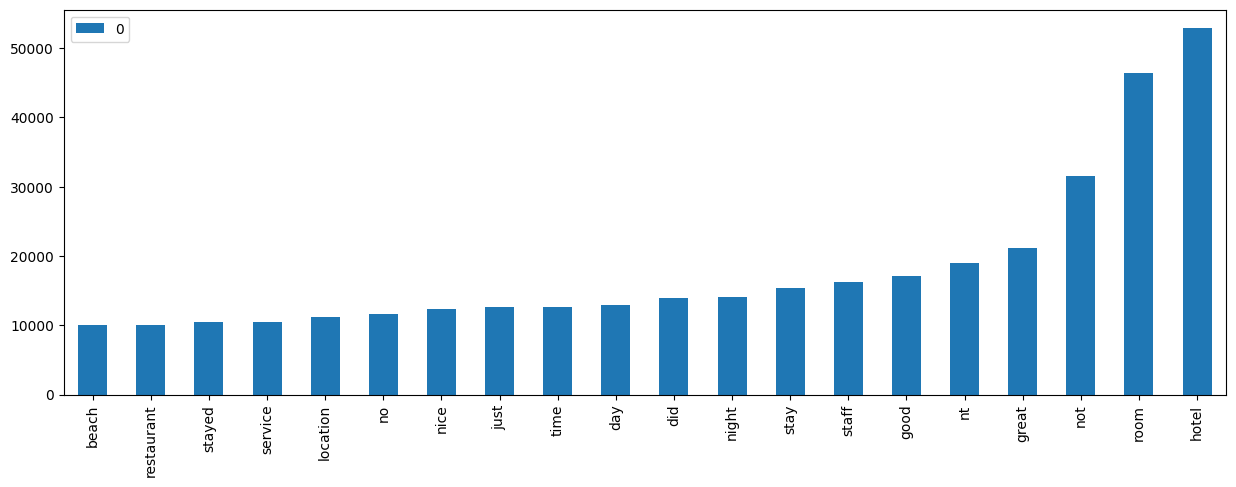

In [8]:
word_occurence_number.sort_values(by=0).iloc[-20:].plot(kind='bar', figsize=(15, 5))

In [9]:
word_occurence_number.describe()

,0
count,71900.000000
mean,29.099499
std,414.316660
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,52901.000000


In [10]:
np.mean(reviews_df.words_number)

102.105997755112

## Dov2vec

In [74]:
# increased to obtain better performce
n_epochs = 32
# the 75% value
# maybe it is even to high, gonna just after performence
# but this will include around 25 % of the occuring words
min_count = 5
# there are no stop words so the window should not be to big
window_size = 2
# first try
vector_size = 32

In [75]:
tagged_words = [doc2vec.TaggedDocument(words=review, tags=[str(i)]) for i, review in enumerate(reviews_df.Review_lemmatized)]

In [76]:
doc2vec_model = doc2vec.Doc2Vec(vector_size=vector_size, min_count=min_count, epochs=n_epochs, window=window_size)
doc2vec_model.build_vocab(tagged_words)
doc2vec_model.train(tagged_words, total_examples=doc2vec_model.corpus_count, epochs=n_epochs)
doc2vec_model.save("doc2vec-vec32-window2.model")

### Trying to verify if the doc2vec embedding worked out

In [294]:
doc2vec_model.dv.most_similar(['12823'])

[('13272', 0.780900776386261),
 ('12389', 0.7765012979507446),
 ('13640', 0.7651512026786804),
 ('3487', 0.7509444355964661),
 ('13029', 0.7467101216316223),
 ('15824', 0.7461361289024353),
 ('11485', 0.7454383373260498),
 ('20222', 0.742376983165741),
 ('2127', 0.7350260615348816),
 ('10388', 0.7345801591873169)]

In [442]:
reviews_df.Review.iloc[19252]

"cool, mean, place cool, mean cool degenerate la wannabe kind way, rooms poorly lit pretentiously decorated electrical outlets hard hey needs electricity, sorry n't need shower bedroom, redeeming factor bed comfortable, not recommend hotel middle-aged business travelers,  "

In [410]:
vector_good = doc2vec_model.infer_vector('Nice open space area. Comfy and relaxing atmosphere. People very cheerful'.split())
vector_bad = doc2vec_model.infer_vector('Discousting food and a lot time to wait for service'.split())
vector_neutral = doc2vec_model.infer_vector('Very nice hotel in bad neighbourhood'.split())

In [441]:
doc2vec_model.dv.most_similar(vector_neutral)

[('19252', 0.6895096302032471),
 ('17592', 0.6786773204803467),
 ('14480', 0.6715874671936035),
 ('12697', 0.6688364148139954),
 ('14596', 0.6615757942199707),
 ('12442', 0.6577968597412109),
 ('142', 0.6547802090644836),
 ('14058', 0.6516783833503723),
 ('1801', 0.6503904461860657),
 ('9418', 0.6413642168045044)]

In [287]:
reviews_df.sort_values(by='words_number').iloc[:10]

,Review,Rating,Review_processed,Review_lemmatized,Review_stopwords,Review_bigrams,words_number,doc2vec,commas,average_length
1501,"loved resort amazing space lot, not bored,",5,loved resort amazing space lot not bored,"[loved, resort, amazing, space, lot, not, bored]","['loved', 'resort', 'amazing', 'space', 'lot',...","[('loved', 'resort'), ('resort', 'amazing'), (...",7,"[-0.05655341, -0.46871337, 0.5748389, 0.296093...",2,3.666667
12823,hotel 9 10. hotel beach 7 10. beautiful sunset...,3,hotel hotel beach beautiful sunsets small ...,"[hotel, hotel, beach, beautiful, sunset, small...","['hotel', 'hotel', 'beach', 'beautiful', 'suns...","[('hotel', 'hotel'), ('hotel', 'beach'), ('bea...",8,"[0.15299292, -0.6659722, 0.023337735, 0.116902...",1,7.500000
488,"issues n't say 4 star service great pool bar,",3,issues nt say star service great pool bar,"[issue, nt, say, star, service, great, pool, bar]","['issue', 'nt', 'say', 'star', 'service', 'gre...","[('issue', 'nt'), ('nt', 'say'), ('say', 'star...",8,"[-0.042760886, -0.6807799, 0.22831817, 0.29165...",1,6.000000
18073,"nice hotel view second room room left row,",5,nice hotel view second room room left row,"[nice, hotel, view, second, room, room, left, ...","['nice', 'hotel', 'view', 'second', 'room', 'r...","[('nice', 'hotel'), ('hotel', 'view'), ('view'...",8,"[0.42589733, -0.60885185, 0.13760035, -0.24760...",1,5.500000
10446,glad stayed great experience stay time steps p...,4,glad stayed great experience stay time steps p...,"[glad, stayed, great, experience, stay, time, ...","['glad', 'stayed', 'great', 'experience', 'sta...","[('glad', 'stayed'), ('stayed', 'great'), ('gr...",9,"[-0.6950405, -0.17748098, 0.014431554, 0.32570...",1,6.000000
4524,"feeling cheated, westin signature comfy bed wi...",4,feeling cheated westin signature comfy bed wil...,"[feeling, cheated, westin, signature, comfy, b...","['feeling', 'cheated', 'westin', 'signature', ...","[('feeling', 'cheated'), ('cheated', 'westin')...",9,"[0.4769751, -0.18838228, -0.47055966, 0.230789...",2,4.333333
16736,clean hotel attentive welcoming staff infinity...,4,clean hotel attentive welcoming staff infinity...,"[clean, hotel, attentive, welcoming, staff, in...","['clean', 'hotel', 'attentive', 'welcoming', '...","[('clean', 'hotel'), ('hotel', 'attentive'), (...",9,"[0.15689844, -0.6512132, -0.20395358, -0.21149...",1,6.000000
16969,"number hotel number ranking, perfect way, best...",5,number hotel number ranking perfect way best b...,"[number, hotel, number, ranking, perfect, way,...","['number', 'hotel', 'number', 'ranking', 'perf...","[('number', 'hotel'), ('hotel', 'number'), ('n...",9,"[0.043602712, -0.559723, 0.3431994, -0.1500593...",3,3.500000
13994,decent place stay price bed right bathroom max...,3,decent place stay price bed right bathroom max...,"[decent, place, stay, price, bed, right, bathr...","['decent', 'place', 'stay', 'price', 'bed', 'r...","[('decent', 'place'), ('place', 'stay'), ('sta...",9,"[-0.48660415, -0.68964833, -0.35068944, -0.277...",1,6.000000
8043,"attitude love space receptionist rude abrupt, ...",2,attitude love space receptionist rude abrupt s...,"[attitude, love, space, receptionist, rude, ab...","['attitude', 'love', 'space', 'receptionist', ...","[('attitude', 'love'), ('love', 'space'), ('sp...",10,"[-0.23012352, 0.3562232, 0.16891563, 0.1396500...",2,4.666667


In [209]:
reviews_df['doc2vec'] = reviews_df.Review_lemmatized.apply(lambda text_list: list(doc2vec_model.infer_vector(text_list)))

In [210]:
reviews_for_classification = reviews_df[['Review', 'Review_lemmatized', 'doc2vec', 'commas', 'words_number', 'average_length', 'Rating']]

### Saving as csv

In [211]:
reviews_for_classification.to_csv('./data/reviews_for_classifiaction.csv', index=False)

### Loading data

In [63]:
reviews_for_classification = pd.read_csv("reviews_for_classifiaction.csv", 
                                        converters={'Review_lemmatized': pd.eval, 'doc2vec': pd.eval})

# Classifiaction

## SVM Classifier

### Classification just on the embedded document
Viviani said on the lecture that while doing classification we should also consider the number of commas, average word length ans ect.

#### Preparing training and test set

In [385]:
# checking if everything is alrigth 
# to delete later
len(reviews_for_classification.doc2vec.iloc[0]) == vector_size

True

In [386]:
X_train, X_test, y_train, y_test = train_test_split(reviews_for_classification.doc2vec.to_list(), 
                                                    reviews_for_classification.Rating, 
                                                    test_size=0.1,
                                                    random_state=42)

In [387]:
len(X_train), len(y_train), len(X_test), len(y_test)

(18441, 18441, 2050, 2050)

In [388]:
svc_simplest_input = SVC(C=2)
svc_simplest_input.fit(X_train, y_train)

SVC(C=2)

#### Model evaluation

In [389]:
y_pred = svc_simplest_input.predict(X_test)

In [390]:
# tried modifing all the hyperparameters but it is the best I obtained 
accuracy_score(y_test, y_pred)

0.5824390243902439

In [391]:
y_train_pred = svc_simplest_input.predict(X_train)

In [392]:
accuracy_score(y_train, y_train_pred)

0.7545686242611572

In [393]:
confusion_M = confusion_matrix(y_test, y_pred)

<AxesSubplot: >

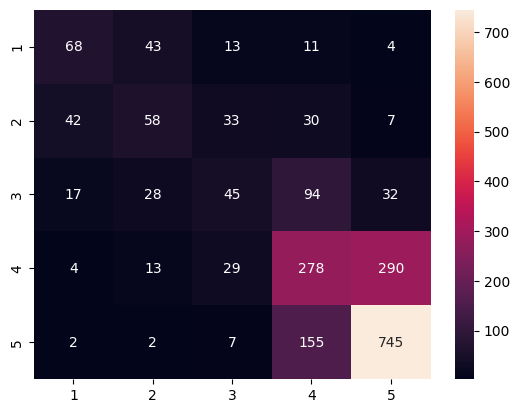

In [397]:
# TODO: deal with exponentials view
possible_reviews = range(1,6)
confusion_M_df = pd.DataFrame(confusion_M, columns=possible_reviews, index=possible_reviews)

sn.heatmap(confusion_M_df, annot=True, fmt='g', annot_kws={"size": 10})

### Classification with other parameters

#### Preparing train and test set

In [198]:
# reviews_for_classification['to_train'] = reviews_for_classification.apply(lambda row: row.doc2vec.extend([row.commas, row.words_number, row.average_length]), axis=1)

C:\Users\jjasi\AppData\Local\Temp\ipykernel_21704\2440993339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_for_classification['to_train'] = reviews_for_classification.apply(lambda row: row.doc2vec.extend([row.commas, row.words_number, row.average_length]), axis=1)


In [395]:
X = []

for _, row in reviews_for_classification.iterrows():
    x = row.doc2vec.copy()
    x.extend([row.words_number, row.commas, row.average_length])
    X.append(x)

len(X[0])

35

In [372]:
X_train, X_test, y_train, y_test = train_test_split(X, reviews_for_classification.Rating, 
                                                    test_size=0.1,
                                                    random_state=42)

In [373]:
len(X_train), len(y_train), len(X_test), len(y_test)

(18441, 18441, 2050, 2050)

In [267]:
# increasing C to weaken the L2 regularization
# at first the classifier was predicting only rating 5
svc_metadata = SVC(C=5)
svc_metadata.fit(X_train, y_train)

SVC(C=5)

#### Model evaluation

In [268]:
y_pred = svc_metadata.predict(X_test)

In [269]:
accuracy_score(y_test, y_pred)

0.5195121951219512

In [270]:
y_train_pred = svc_metadata.predict(X_train)

In [271]:
accuracy_score(y_train, y_train_pred)

0.5161867577680169

<AxesSubplot: >

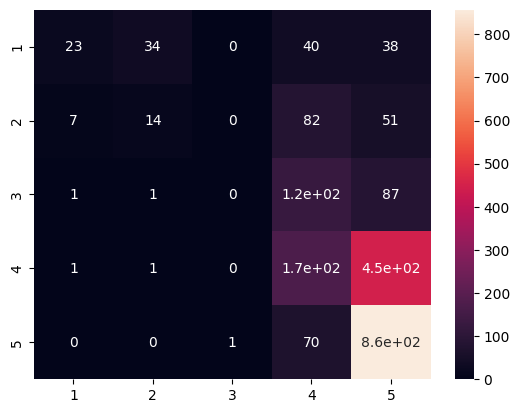

In [273]:
# TODO: deal with exponentials view
confusion_M = confusion_matrix(y_test, y_pred)

possible_reviews = range(1,6)
confusion_M_df = pd.DataFrame(confusion_M, columns=possible_reviews, index=possible_reviews)

sn.heatmap(confusion_M_df, annot=True, fmt='g', annot_kws={"size": 10})

The model with simpler input works better so from now it will be just this one used

## KNeighborsClassifier

In [398]:
# since it is a very fast non-parametrical algoritm
accuracies = []

for n_neighbours in range(1, 50):
    KNC = KNeighborsClassifier(n_neighbors=n_neighbours)
    KNC.fit(X_train, y_train)
    y_pred = KNC.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

In [399]:
best_n_neighbours = np.argmax(accuracies) + 1

In [400]:
KNC = KNeighborsClassifier(n_neighbors=best_n_neighbours)
KNC.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=24)

In [401]:
y_pred = KNC.predict(X_test)

In [402]:
accuracy_score(y_test, y_pred)

0.5487804878048781

<AxesSubplot: >

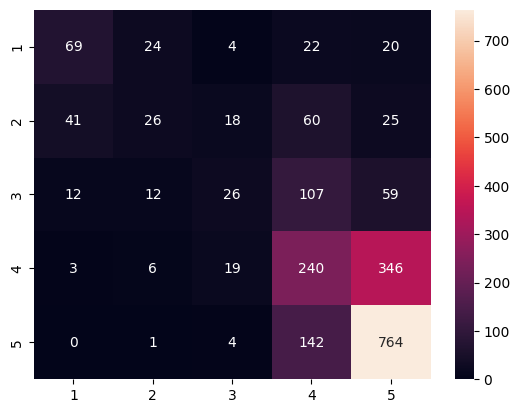

In [403]:
# TODO: deal with exponentials view
confusion_M = confusion_matrix(y_test, y_pred)

possible_reviews = range(1,6)
confusion_M_df = pd.DataFrame(confusion_M, columns=possible_reviews, index=possible_reviews)

sn.heatmap(confusion_M_df, annot=True, fmt='g', annot_kws={"size": 10})

## Random Forest

In [404]:
RFC = RandomForestClassifier(max_depth=10, random_state=42)

In [405]:
RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [406]:
y_pred = RFC.predict(X_test)

In [407]:
accuracy_score(y_test, y_pred)

0.5448780487804878

<AxesSubplot: >

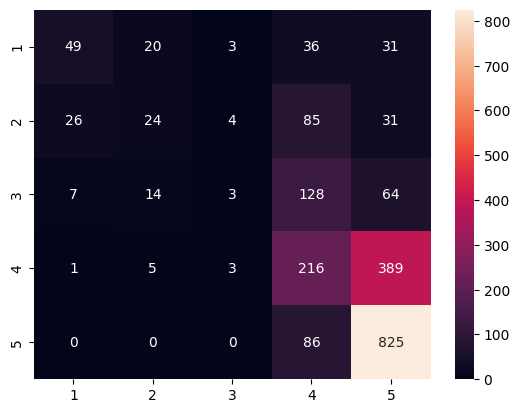

In [408]:
# TODO: deal with exponentials view
confusion_M = confusion_matrix(y_test, y_pred)

possible_reviews = range(1,6)
confusion_M_df = pd.DataFrame(confusion_M, columns=possible_reviews, index=possible_reviews)

sn.heatmap(confusion_M_df, annot=True, fmt='g', annot_kws={"size": 10})

## Neural networks

### FNN

In [ ]:
# Should we even try it?